In [1]:
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
import random
import ipyplot

from utils import *

load_dotenv()
Migrator().run()

In [2]:
query = "volume1"
delete = Model.find(Model.filename % query).all()
for r in tqdm(delete, desc="Deleting existing keys"):
    try:
        Model.delete(r.pk)
    except Exception as e:
        print("There was an exception with {}\n{}".format(r, e))

Deleting existing keys:   0%|          | 0/12342 [00:00<?, ?it/s]

In [3]:
query = "wedding*moose"

filenames = index_directory(CONTAINER_IMAGE_FOLDER, formats=(".png", ".jpeg", ".jpg"))

for filename in tqdm(filenames, desc="Writing filenames to redis db."):
    try:
        Model(filename=filename, size=0).save()
    except Exception as e:
        print("There was an exception with {}\n{}".format(filename, e))

models = Model.find(Model.filename % query).all()

Indexed 12,342 file(s) in 2.538 seconds.


Writing filenames to redis db.:   0%|          | 0/12342 [00:00<?, ?it/s]

In [4]:
triton_client = grpcclient.InferenceServerClient(url=TRITON_SERVER_URL, verbose=False)

model_metadata = triton_client.get_model_metadata(
    model_name=FACE_DETECT_MODEL_NAME, model_version=MODEL_VERSION
)

model_config = triton_client.get_model_config(
    model_name=FACE_DETECT_MODEL_NAME, model_version=MODEL_VERSION
).config

input_names = [i.name for i in model_config.input]
output_names = [i.name for i in model_config.output]
print("expected input names:{}".format(input_names))

print("expected output names:{}".format(output_names))

expected input names:['input_image_data']
expected output names:['true_boxes', 'true_proba', 'true_image_size']


In [5]:
pbar = tqdm(
    total=len(models),
    desc="Submitting photos to {} at {}".format(
        FACE_DETECT_MODEL_NAME, TRITON_SERVER_URL
    ),
)

results = []

with ThreadPoolExecutor() as executor:
    for chunk in chunked(models, THREAD_CHUNKS):
        futures = []
        for model in chunk:
            futures.append(
                executor.submit(
                    submit_to_facedetect,
                    model.filename,
                    input_names,
                    output_names,
                    model.pk,
                )
            )

        for future in as_completed(futures):
            pbar.update()
            try:
                infer_result = future.result()
                model = Model.get(infer_result.get_response().id)
                image_wise_bboxes = infer_result.as_numpy(output_names[0]).reshape(
                    -1, 4
                )
                image_probas = infer_result.as_numpy(output_names[1]).reshape(-1, 1)

                h, w, c = infer_result.as_numpy(output_names[2]).squeeze()
                model.channels = int(c)
                model.height = int(h)
                model.width = int(w)

                for bbox, proba in zip(image_wise_bboxes, image_probas):
                    model.faces = [
                        {
                            "bbox": {
                                "x1": int(round(bbox[0], 0)),
                                "y1": int(round(bbox[1], 0)),
                                "x2": int(round(bbox[2], 0)),
                                "y2": int(round(bbox[3], 0)),
                            },
                            "probability": int(round(proba[0], 0)),
                        }
                        for bbox, proba in zip(image_wise_bboxes, image_probas)
                    ]
                model.save()

            except Exception as e:
                print("There was an exception: {}.".format(e))

Submitting photos to facenet_ensemble at 172.25.4.42:8001:   0%|          | 0/728 [00:00<?, ?it/s]

Looks like /volume1/brandon/pictures/2015-wedding-moose-photos/ab_hawk_hollow_wedding_lansing-136.jpeg has 2 faces.

{'pk': '01GK2GVFC0BWFF3WS9HHZY9CNR', 'filename': '/volume1/brandon/pictures/2015-wedding-moose-photos/ab_hawk_hollow_wedding_lansing-136.jpeg', 'faces': [{'pk': '01GK2GVZSSSB2BJRSNKEYC6JCR', 'bbox': {'pk': '01GK2GVZSSWE2DJZ4Y302GS4EE', 'x1': 2118, 'y1': 735, 'x2': 2496, 'y2': 1235}, 'probability': 8, 'label': None, 'rotation': None, 'descriptors': None}, {'pk': '01GK2GVZSS7S157W3QDZJQ95J6', 'bbox': {'pk': '01GK2GVZSS5QSEZ6R8FPNB9Z77', 'x1': 3411, 'y1': 837, 'x2': 3800, 'y2': 1333}, 'probability': 9, 'label': None, 'rotation': None, 'descriptors': None}], 'channels': 3, 'height': 3355, 'width': 5032, 'size': 0}


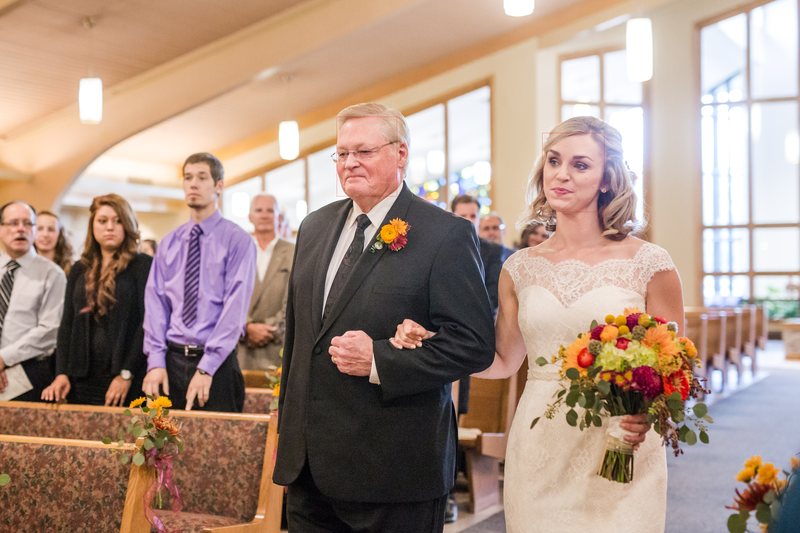

In [6]:
# Re-query since it's all been updated.
models = Model.find(Model.filename % query).all()

for model in models:
    try:
        if len(model.faces) == 2:
            print(
                "Looks like {} has {} faces.\n".format(model.filename, len(model.faces))
            )
            break
        else:
            continue
    except:
        pass
print(model.dict())

render_image(model, output_size=800)

___